<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller

In [2]:
pth1 = '/datasets/taxi.csv'
pth2 = 'C:/datasc/pracfiles/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
print('min:', df.index.min(), '\nmax:', df.index.max())

min: 2018-03-01 00:00:00 
max: 2018-08-31 23:50:00


In [5]:
df = df.resample('1H').sum()

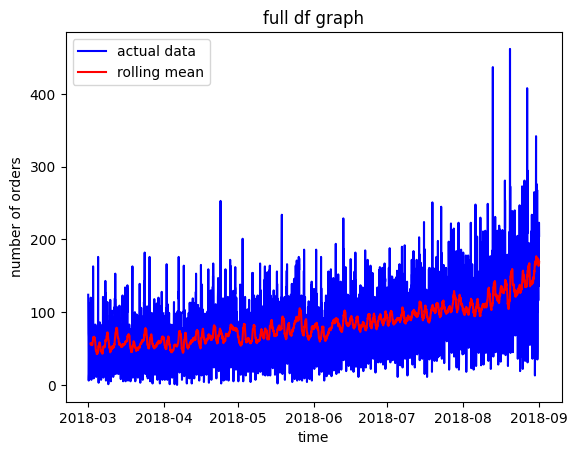

In [6]:

plt.plot(df, 'b', label='actual data')
plt.plot(df['num_orders'].rolling(24, closed='left').mean(), 'r', label='rolling mean')
plt.title('full df graph')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.legend()
plt.show()

Непостоянность скользящей средней указывает на нестационарность ряда

## Анализ

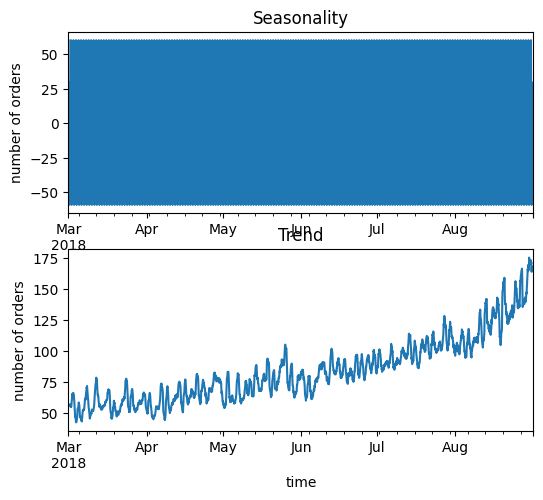

In [7]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('time')
plt.ylabel('number of orders')
plt.title('Trend')
plt.show()

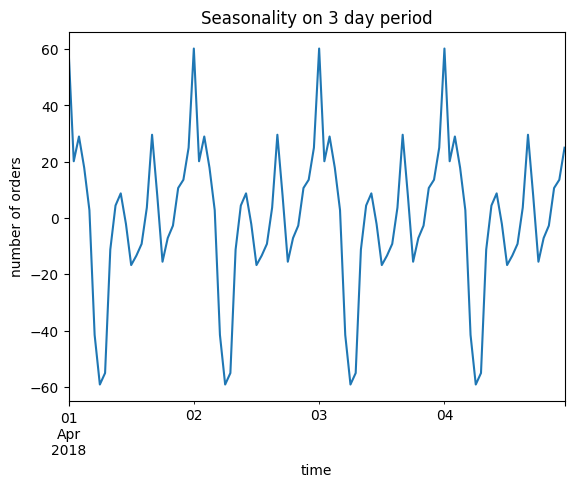

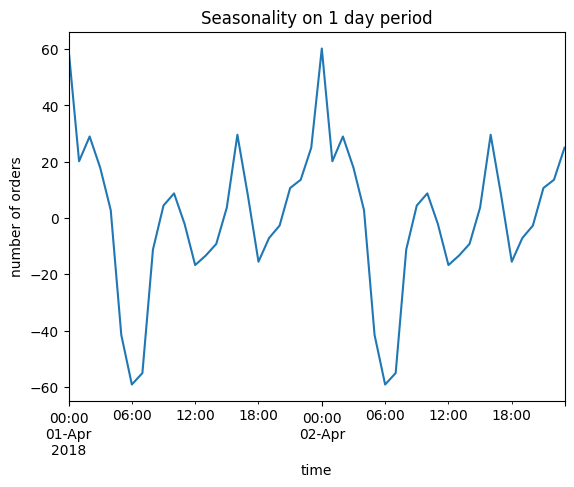

In [8]:
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-04-01':'2018-04-4'].plot()
plt.title('Seasonality on 3 day period')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()
decomposed.seasonal['2018-04-01':'2018-04-2'].plot()
plt.title('Seasonality on 1 day period')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

Сезонность у нас суточная, минимум достигается в 6 утра, а максимум в 0:00 часов с еще двумя локальными максимумами в 10 и 16 часов и локальными миниумами в 12 и 18 часов  
Так как у нас данные о заказах такси у аэропортов наиболее вероятно это связано с расписанием рейсов самолетов 

Проведем тест Дики - Фуллера на стационарность временного ряда  
Нулевая гипотеза H0: Ряд нестационарен  
Альтернативная гипотеза HA: Ряд стационарен

In [9]:
alpha1 = 0.05
alpha2 = 0.01 
pvalue = adfuller(df)[1]
if pvalue > alpha1:
    print('Для уровня занчимости 5% не можем отвергнуть нулевую гипотезу и ряд нестационарен')
else:
    print('Для уровня занчимости 5% ряд стационарен')
if pvalue > alpha2:
    print('Для уровня занчимости 1% не можем отвергнуть нулевую гипотезу и ряд нестационарен')
else:
    print('Для уровня занчимости 1% ряд стационарен')


Для уровня занчимости 5% ряд стационарен
Для уровня занчимости 1% не можем отвергнуть нулевую гипотезу и ряд нестационарен


In [10]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].rolling(rolling_mean_size).mean()
    return new_data

In [11]:
df = make_features(df, 24, 24)

In [12]:
df.head(10) 

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка

In [13]:
df = df.dropna()
df.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,55.416667
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,56.875000
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,57.041667
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.958333
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.000000


In [14]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

In [15]:
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345, shuffle=False)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345, shuffle=False)
print(features_train_val.index.max())
print(target_test.index.min())

print(features_train.index.max())
print(target_valid.index.min())

2018-08-13 15:00:00
2018-08-13 16:00:00
2018-07-03 11:00:00
2018-07-03 12:00:00


In [16]:
dates_valid = features_valid.index
dates_test = features_test.index

In [17]:
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Моделирование

In [18]:
dummy = [target_train.mean() for i in range(len(target_valid))]
print(dummy[0:5])
print('DUMMY\nrmse:', mean_squared_error(target_valid, dummy) ** 0.5)

[69.99527665317139, 69.99527665317139, 69.99527665317139, 69.99527665317139, 69.99527665317139]
DUMMY
rmse: 53.1328035360773


LINEAR
rmse: 4.864777715170293e-13


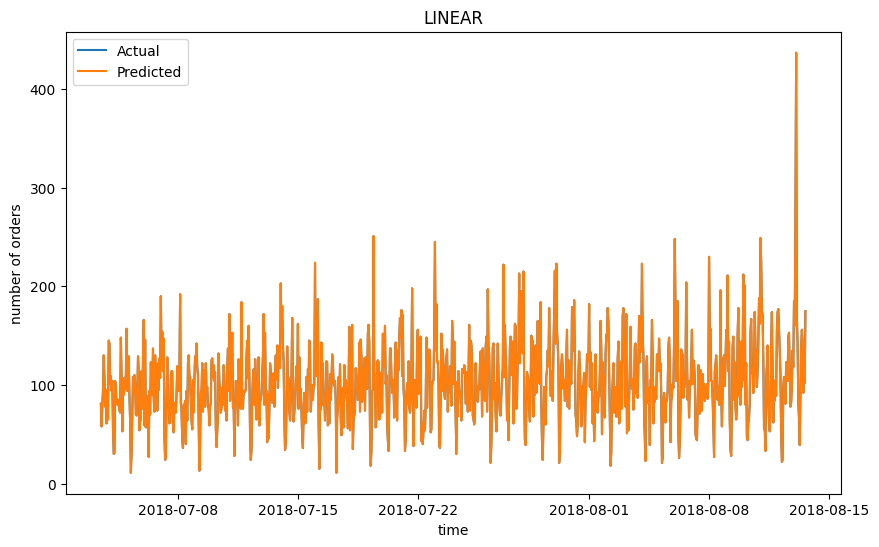

In [19]:
linear = LinearRegression()
linear.fit(features_train, target_train)
pred = linear.predict(features_valid)
print('LINEAR\nrmse:', mean_squared_error(target_valid, pred) ** 0.5)
plt.figure(figsize=(10, 6))
plt.plot(dates_valid, target_valid, label='Actual')
plt.plot(dates_valid, pred, label='Predicted')
plt.legend()
plt.title('LINEAR')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

практически идеальное предсказание

In [20]:
%%time
cat_model = catboost.CatBoostRegressor(silent=True, random_seed=12345)

CPU times: total: 0 ns
Wall time: 4 ms


catboost
rmse: 32.61103736574046


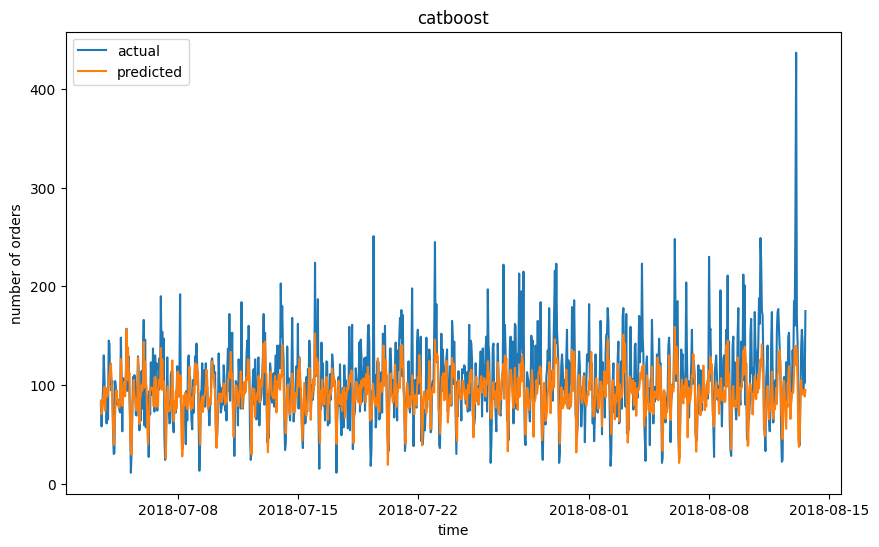

In [21]:
cat_model.fit(features_train, target_train)
pred = cat_model.predict(features_valid)
rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'catboost\nrmse:', rmse)
plt.figure(figsize=(10, 6))
plt.plot(dates_valid, target_valid, label='actual')
plt.plot(dates_valid, pred, label='predicted')
plt.legend()
plt.title('catboost')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

в целом модель довольно точно предсказывает, однако предсказывает максимумы еще хуже чем линейная регрессия, но минимумы предсказывает лучше

модель плохо предсказывает максимумы настоящих данных, но хорошо предсказывает минимумы 

svr
rmse: 42.53517314957791


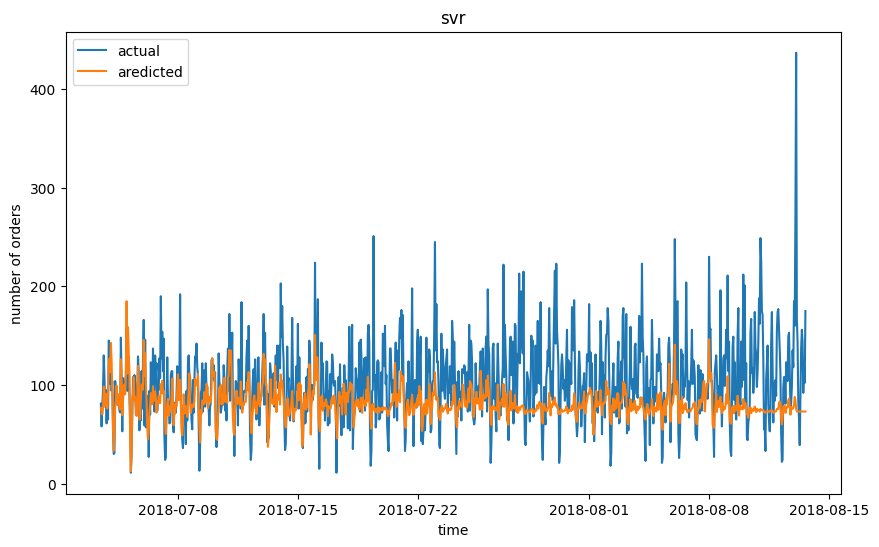

In [22]:
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model.fit(features_train, target_train)

pred = model.predict(features_valid)

rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'svr\nrmse:', rmse)

plt.figure(figsize=(10, 6))
plt.plot(dates_valid, target_valid, label='actual')
plt.plot(dates_valid, pred, label='aredicted')
plt.legend()
plt.title('svr')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

в целом модель довольно точно предсказывает, однако из слабых сторон можно заметить меньшую дисперсию, нежели у фактических данных, еще меньше чем у линейной регрессии, поэтому не совсем хорошо предсказывает предсказывает выдающиеся максимумы и минимумы

RIDGE
rmse: 2.386404314893486


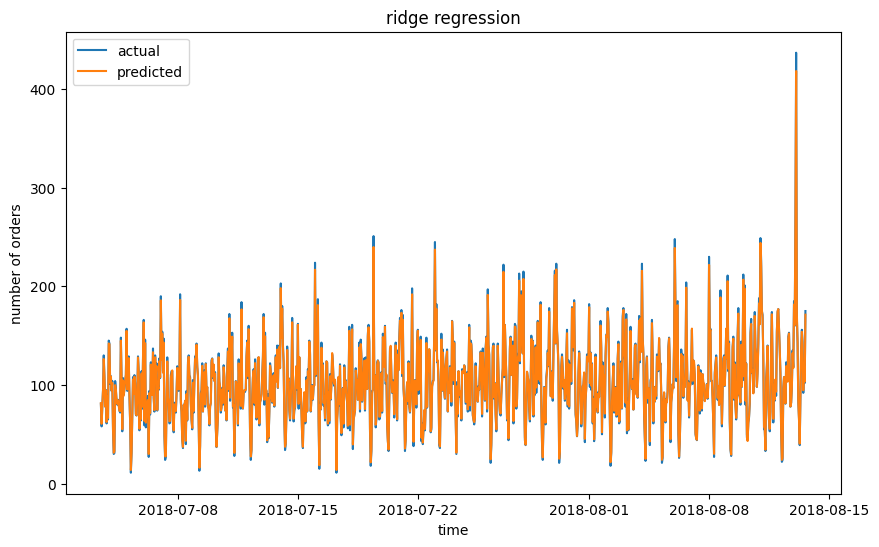

In [23]:
model = Ridge(alpha=1.0)
model.fit(features_train, target_train)

pred = model.predict(features_valid)
rmse = mean_squared_error(target_valid, pred) ** 0.5
print(f'RIDGE\nrmse: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(dates_valid, target_valid, label='actual')
plt.plot(dates_valid, pred, label='predicted')
plt.legend()
plt.title('ridge regression')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

в принципе ничем не отличается от стандартной линейной регрессии

По итогам сравнения моделей на valid выборке, науилучшую метрику rmse (порядка 26) заняла модель линейной регрессии без регуляризации

## Тестирование

In [24]:
cat_features = np.concatenate((features_train, features_valid), axis=0)
cat_target = np.concatenate((target_train, target_valid), axis=0)

FINAL
rmse: 9.151613902530747e-13


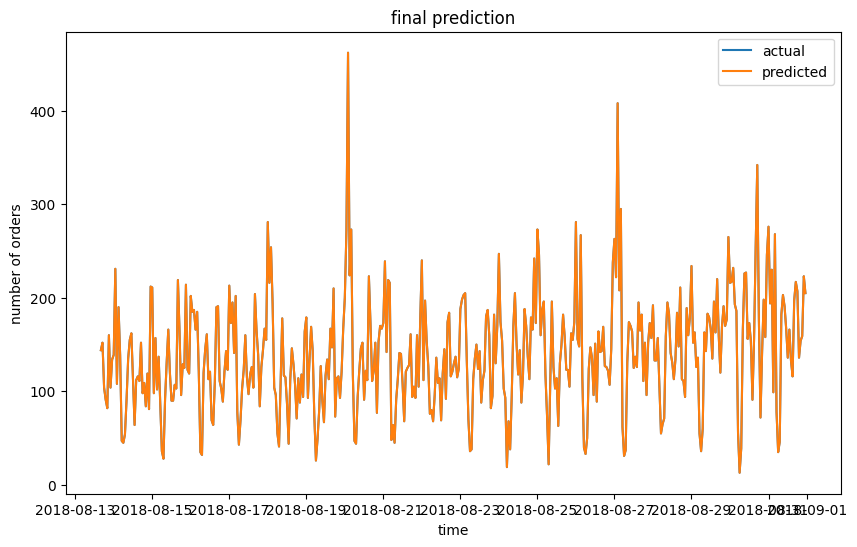

In [25]:
fin_model = LinearRegression()
fin_model.fit(cat_features, cat_target)
pred = linear.predict(features_test)
rmse = mean_squared_error(target_test, pred) ** 0.5
print('FINAL\nrmse:', rmse)

plt.figure(figsize=(10, 6))
plt.plot(dates_test, target_test, label='actual')
plt.plot(dates_test, pred, label='predicted')
plt.legend()
plt.title('final prediction')
plt.xlabel('time')
plt.ylabel('number of orders')
plt.show()

В целом модель неплохо предсказывает, но минимумы и максимумы могла бы предсказывать лучше

## Итоги

Исходные данные нестационарны  
К данным были добавлены столбцы с 5 shift колонками и одной скользящим средним  
Наилучшей в метрике rmse оказалась обычная модель линейной регрессии с показателем rmse на тестовой выборке в 34